# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

seed = 12345
data = pd.read_csv('/datasets/faces/labels.csv')


>Посмотрим на размер выборки.

In [2]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
data.shape

(7591, 2)

>Постоим график распределения возраста в выборке.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


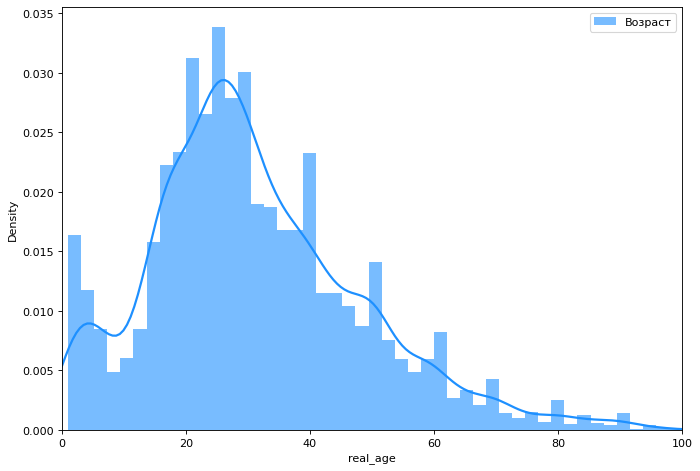

In [5]:
x1 = data['real_age']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Возраст", **kwargs)

plt.xlim(0,100)
plt.legend();

Прослеживается несколько пиков возраста: от рождения до 3-5 лет, и самый большой пик - от 20 до 35 лет.

>Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


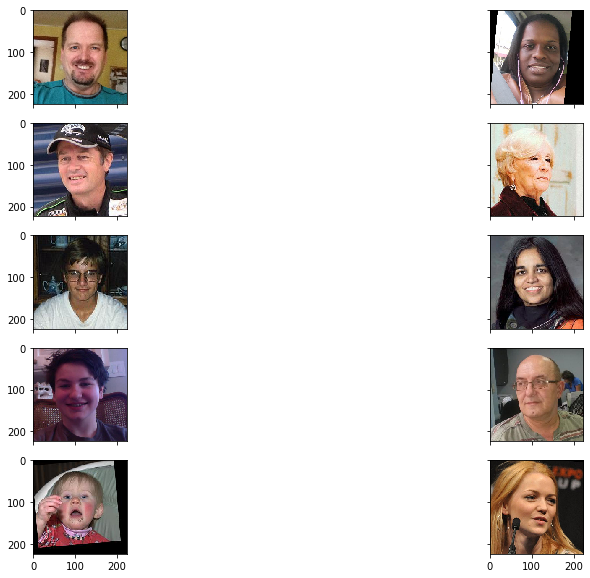

In [7]:
x,y  = train_gen_flow.next()

fig, axes = plt.subplots(ncols=2,nrows=5, sharex=True, sharey=True, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(x[i], interpolation='none')

plt.show()

In [8]:
x.shape

(32, 224, 224, 3)

>Вывод

- Датасет сотоит из двух колонок file_name и real_age.
- Размер выборки 7591.
- Получили четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.
 
Изображения лиц на фтото разного размера, поворот головы разный (фас, анфас, профиль), некоторые изображения сдвинуты (по горизонтали и вертикали), фото разных цветов.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# функция загрузки тренировочной выборки
def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow

# функция загрузки тестовой выборки
def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

# функция создания модели неиросети
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model

# функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
# < скопируем результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

2022-06-25 13:14:39.309953: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-06-25 13:14:39.311763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-06-25 13:14:40.176636: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-25 13:14:40.856067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-25 13:14:40.856148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-25 13:14:40.856181: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-25 13:14:40.857944: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-25 13:14:40.858367: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-25 13:14:40.860564: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-25 13:14:40.861714: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-25 13:14:40.861801: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-25 13:14:40.866271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-25 13:14:40.866662: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-06-25 13:14:40.873594: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-06-25 13:14:40.874172: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x57ac830 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-25 13:14:40.874202: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-25 13:14:41.018626: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5bf8e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-25 13:14:41.018688: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-06-25 13:14:41.021608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-25 13:14:41.021715: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-25 13:14:41.021734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-25 13:14:41.021814: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-25 13:14:41.021838: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-25 13:14:41.021858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-25 13:14:41.021876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-25 13:14:41.021889: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-25 13:14:41.027043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-25 13:14:41.027143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-25 13:14:41.351397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-25 13:14:41.351455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-06-25 13:14:41.351463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-06-25 13:14:41.356084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-06-25 13:14:51.998580: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-25 13:14:52.293476: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 63s - loss: 217.6023 - mae: 11.1182 - val_loss: 969.3692 - val_mae: 26.1312
Epoch 2/20
356/356 - 37s - loss: 134.4763 - mae: 8.8911 - val_loss: 313.3494 - val_mae: 13.3998
Epoch 3/20
356/356 - 37s - loss: 109.8850 - mae: 7.9815 - val_loss: 121.9317 - val_mae: 8.6420
Epoch 4/20
356/356 - 37s - loss: 89.4414 - mae: 7.2646 - val_loss: 113.0123 - val_mae: 7.9885
Epoch 5/20
356/356 - 37s - loss: 79.1274 - mae: 6.7865 - val_loss: 97.7720 - val_mae: 7.6462
Epoch 6/20
356/356 - 37s - loss: 62.7785 - mae: 6.0854 - val_loss: 122.4381 - val_mae: 8.3798
Epoch 7/20
356/356 - 38s - loss: 57.9557 - mae: 5.8208 - val_loss: 95.1647 - val_mae: 7.3437
Epoch 8/20
356/356 - 38s - loss: 46.3820 - mae: 5.2546 - val_loss: 210.0830 - val_mae: 11.5920
Epoch 9/20
356/356 - 38s - loss: 44.2981 - mae: 5.1483 - val_loss: 121.5732 - val_mae: 8.1461
Epoch 10/20
356/356 - 38s - loss: 34.5116 - mae: 4.5546 - val_loss: 90.2072 - val_mae: 6.9916
Epoch 11/20
356/356 - 38s - loss: 32.4804 - mae: 4.4024 - val_loss: 86.9531 - val_mae: 7.0258
Epoch 12/20
356/356 - 37s - loss: 27.4854 - mae: 4.0487 - val_loss: 97.2177 - val_mae: 7.3747
Epoch 13/20
356/356 - 37s - loss: 23.5499 - mae: 3.7425 - val_loss: 85.1112 - val_mae: 6.8869
Epoch 14/20
356/356 - 37s - loss: 23.4719 - mae: 3.7083 - val_loss: 91.5972 - val_mae: 7.1220
Epoch 15/20
356/356 - 37s - loss: 23.6701 - mae: 3.7308 - val_loss: 89.7028 - val_mae: 7.1178
Epoch 16/20
356/356 - 37s - loss: 23.0869 - mae: 3.6727 - val_loss: 83.5893 - val_mae: 6.7188
Epoch 17/20
356/356 - 37s - loss: 19.1128 - mae: 3.3860 - val_loss: 78.6087 - val_mae: 6.5399
Epoch 18/20
356/356 - 37s - loss: 18.0253 - mae: 3.2829 - val_loss: 90.3709 - val_mae: 7.1870
Epoch 19/20
356/356 - 37s - loss: 16.8300 - mae: 3.1571 - val_loss: 94.7136 - val_mae: 7.3232
Epoch 20/20
356/356 - 37s - loss: 17.9030 - mae: 3.2351 - val_loss: 105.3187 - val_mae: 7.9818
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 105.3187 - mae: 7.9818
Test MAE: 7.9818

```

## Анализ обученной модели

>Выводы

В нашем распоряжении набор фотографий людей с указанием возраста.

Построили и обучили свёрточную нейронную сеть на датасете с фотографиями людей. Добились значения MAE на тестовой выборке не больше 8. Для выполнения поставленной задачи применили архитектуру ResNet50 с одним нейроном на выходе и функцией активации RELU.

Эта модель подходит для определения приблизительного возраста человека по фотографии. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.

Однако с точностью опредять возраст совершеннолетия между 16, 17 и 18 лет - под вопросом. 